In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cma
from es import *
from electrolyser import Electrolyser
from network_arch import Agent
from simulation import get_agent_working_result, estimate_results

In [2]:
import copy

In [3]:
agent = Agent()

In [4]:

def apply_solution(solution):

    agent.updateParams(solution)

    [total_Production_in_dinamics,
     desired_total_Production_in_dinamics,
     Production_Error_in_dinamics,

     total_cost_of_work_for_elecs,
     total_run_out_for_elecs,

     Outs,
     Temperatures,
     States,
     Targets,
     switch_nums_for_elecs,
     Control_signals,

     Output_derivative_for_elecs,
     Output_dderivative_for_elecs]                                       = get_agent_working_result(agent)

    return [Production_Error_in_dinamics, total_run_out_for_elecs, switch_nums_for_elecs,
            total_Production_in_dinamics, desired_total_Production_in_dinamics]


In [5]:
param_count = 0
for param in agent.model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([50, 99])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])
8060


In [6]:
solution = np.random.rand(8060,1) * 6 - 3 # случайное решение можно оценить до начала обучения

In [7]:
import pickle

In [8]:
file_es = open('serialised_data_CMAES_MarkovDelta_t/evalution_strategy.pkl', 'rb')
old_es = pickle.load(file_es)
file_es.close()

In [9]:
# PEPG, CMA ES, SimpleGA search

sigma_init = 0.5 # 0.1

popsize = 100

es = CMAES(num_params=param_count, sigma_init = sigma_init, popsize=popsize)

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 8060 (seed=315079, Fri Mar 25 18:11:06 2022)


In [10]:
es.es = old_es

del old_es

In [11]:

file_params = open('serialised_data_CMAES_MarkovDelta_t/best_params.pkl', 'rb')

file_log = open('serialised_data_CMAES_MarkovDelta_t/logs_relu_linear_norm_2out.pkl', 'rb')
file_dict_score_solution = open('serialised_data_CMAES_MarkovDelta_t/score_solution_relu_linear_norm_2out__number3.pkl', 'rb')


best_params = pickle.load(file_params)

best_scores_in_generations_log = pickle.load(file_log)
max_min_score_solution = pickle.load(file_dict_score_solution)


file_params.close()

file_log.close()
file_dict_score_solution.close()




In [12]:

#es.es.x0 = copy.deepcopy(best_params)



# best_scores_in_generations_log = []

# best_score_solution = [-np.inf, solution.copy()] # [best_score, best_solution]
# worst_score_solution = [0, solution.copy()]



In [13]:


best_score_solution = max_min_score_solution[0]
worst_score_solution = max_min_score_solution[1]


In [14]:

def train_for_some_generations(generations_num):

    for i in range(generations_num):

        solutions = es.ask()

        reward_list = []

        solut_number = 0
        for solution in solutions: # можно параллельно

            [Production_Error_in_dinamics, total_run_out_for_elecs, switch_nums_for_elecs,
            total_Production_in_dinamics, desired_total_Production_in_dinamics] = apply_solution(solution)
            score = estimate_results([Production_Error_in_dinamics, total_run_out_for_elecs])[0] # get cost functions value at point solution

            reward_list.append(score)

            print(str(solut_number) + ' solution is aplied, score = ' + str(score) + '  min-max = ' + str(min(solution)) + ' -- ' + str(max(solution)))

            if score > best_score_solution[0]:
                best_score_solution[0] = copy.deepcopy(score)
                best_score_solution[1] = copy.deepcopy(solution)
                
            if score < worst_score_solution[0]:
                worst_score_solution[0] = copy.deepcopy(score)
                worst_score_solution[1] = copy.deepcopy(solution)
            
            solut_number += 1

        es.tell(reward_list)

        es_solution = es.result()

#         model_params = es_solution[0] # best historical solution

        best_reward = es_solution[1] # best reward
        curr_best_reward = es_solution[2] # best of the current batch

        curr_best_reward_my_for_validation = max(reward_list) # min with '-'

        print(str(i) + "  ==>>", end=' ')
        print(curr_best_reward_my_for_validation, end=' === ')
        print(curr_best_reward, end=' === ')
        print(best_reward, end=' === ')
        print(es.rms_stdev())


        best_scores_in_generations_log.append(curr_best_reward_my_for_validation)
        

    return [es.result(), es.current_param()] # best historical solution

# PEPG search

# максимизируем функцию estimate_sulution(solution)

# 3000h in steady equal to 500h in cycling as a ratio and the cycle length could be 2h On 4h Off




In [ ]:
%%time

train_Report = train_for_some_generations(1)


In [1]:
curr_solution = train_Report[1]

NameError: name 'train_Report' is not defined

In [1]:
best_solution = train_Report[0][0]

NameError: name 'train_Report' is not defined

In [37]:

print(len(best_scores_in_generations_log))

576


In [38]:
best_solution_ever = copy.deepcopy(best_score_solution[1])


In [39]:
print(best_solution_ever)

[ 2.11458578 -1.21752594  0.2267015  ...  0.78595402  2.76503856
  0.20716801]


In [40]:
print(best_solution)

[ 2.11458578 -1.21752594  0.2267015  ...  0.78595402  2.76503856
  0.20716801]


In [41]:
print(curr_solution)

[ 1.41232504 -2.94749457 -1.54932495 ...  1.14589915  1.7102364
 -0.22209642]


In [42]:
print(best_score_solution)

[-29.78690810245181, array([ 2.11458578, -1.21752594,  0.2267015 , ...,  0.78595402,
        2.76503856,  0.20716801])]


In [43]:
print(worst_score_solution)

[-899.52665674101, array([ 0.22402852, -0.13147025,  0.28424935, ..., -0.14231003,
       -0.09515051, -0.85830594])]


In [44]:
%%time

[Production_Error_in_dinamics, total_run_out_for_elecs, switch_nums_for_elecs,
            total_Production_in_dinamics, desired_total_Production_in_dinamics] = apply_solution(best_solution) #

[neg_J, RMSE, mean_error, asymetric_error, max_total_run_out, run_out_deviation_RMSE] = estimate_results([Production_Error_in_dinamics, total_run_out_for_elecs])

print('=========================== SCORE')
print('neg_J = ' + str(neg_J))
print('RMSE = ' + str(RMSE))
print('mean_error = ' + str(mean_error))
print('asymetric_error = ' + str(asymetric_error))
print('max_total_run_out = ' + str(max_total_run_out))
#print(min_max_tot_run_out)
print('run_out_deviation_RMSE = ' + str(run_out_deviation_RMSE))
print("switc num = ", end=' ')
print(switch_nums_for_elecs)
print(sum(switch_nums_for_elecs))

# random

# best -35
# neg_J = -49.48215462662633
# RMSE = 159.28549823669758
# mean_error = -15.776771911330563
# asymetric_error = 3.2574091075081335
# max_total_run_out = 39301.89999999208
# run_out_deviation_RMSE = 12949.266705779768
# switc num =  [7 1 1 5 2]
# 16

# curr
# neg_J = -58.77654455635961
# RMSE = 191.74497797489178
# mean_error = -22.351980738696692
# asymetric_error = 5.502065819459573
# max_total_run_out = 7631.900000007858
# run_out_deviation_RMSE = 0.0
# switc num =  [1 1 1 1 1]
# 5



=========================== SCORE
neg_J = -51.82018109570354
RMSE = 165.20999568260336
mean_error = -1.5272034007161164
asymetric_error = 2.1327430672310452
max_total_run_out = 66939.59999998822
run_out_deviation_RMSE = 24592.088873827903
switc num =  [ 3 12  3  1 11]
30
CPU times: user 2.28 s, sys: 8.07 ms, total: 2.29 s
Wall time: 2.34 s


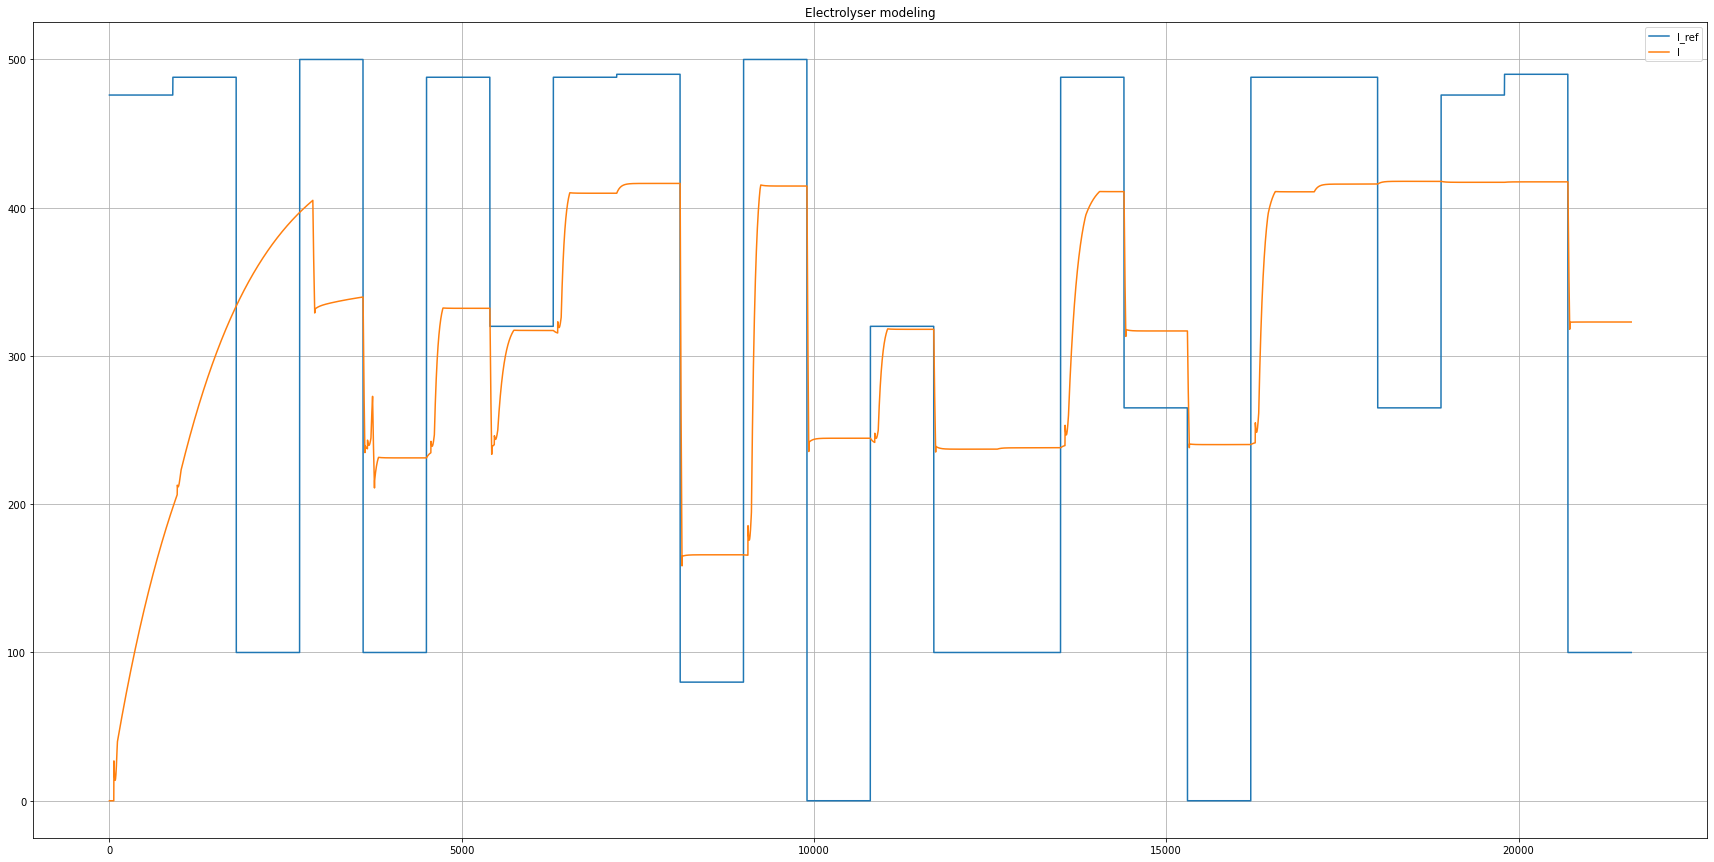

In [45]:
plt.figure(figsize=(30, 15))
plt.title("Electrolyser modeling")
plt.plot(desired_total_Production_in_dinamics, label='I_ref')
plt.plot(total_Production_in_dinamics, label='I')

plt.legend()
plt.grid(visible=True)

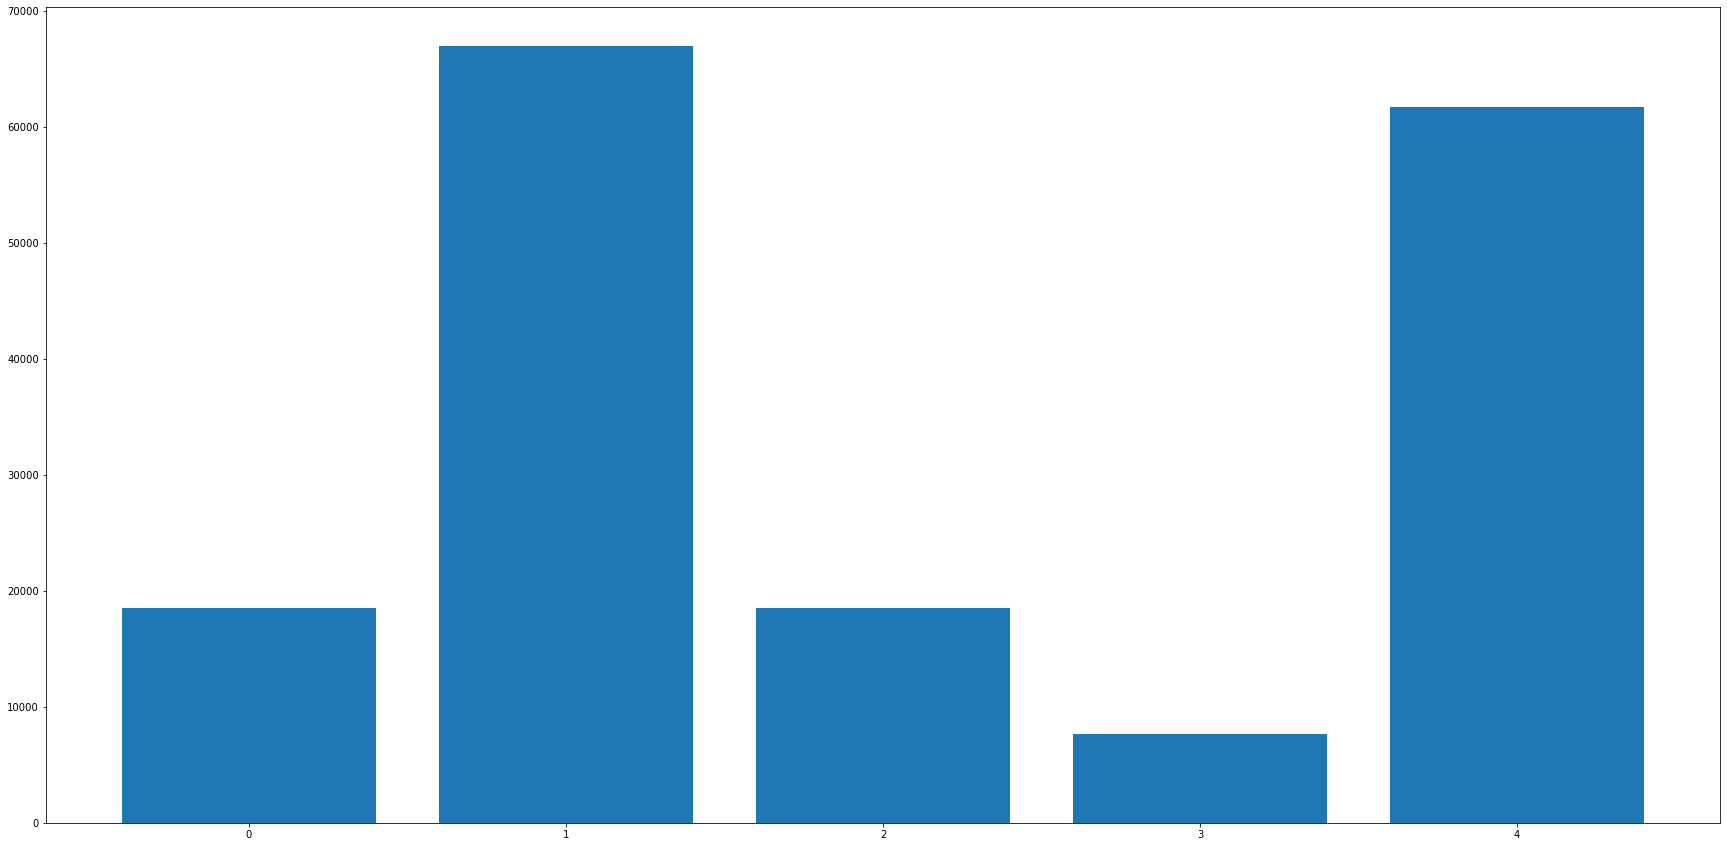

In [46]:
num_elecs = 5
names = list(range(num_elecs))
values = total_run_out_for_elecs

plt.figure(figsize=(30, 15))
plt.bar(names, values)
plt.show()

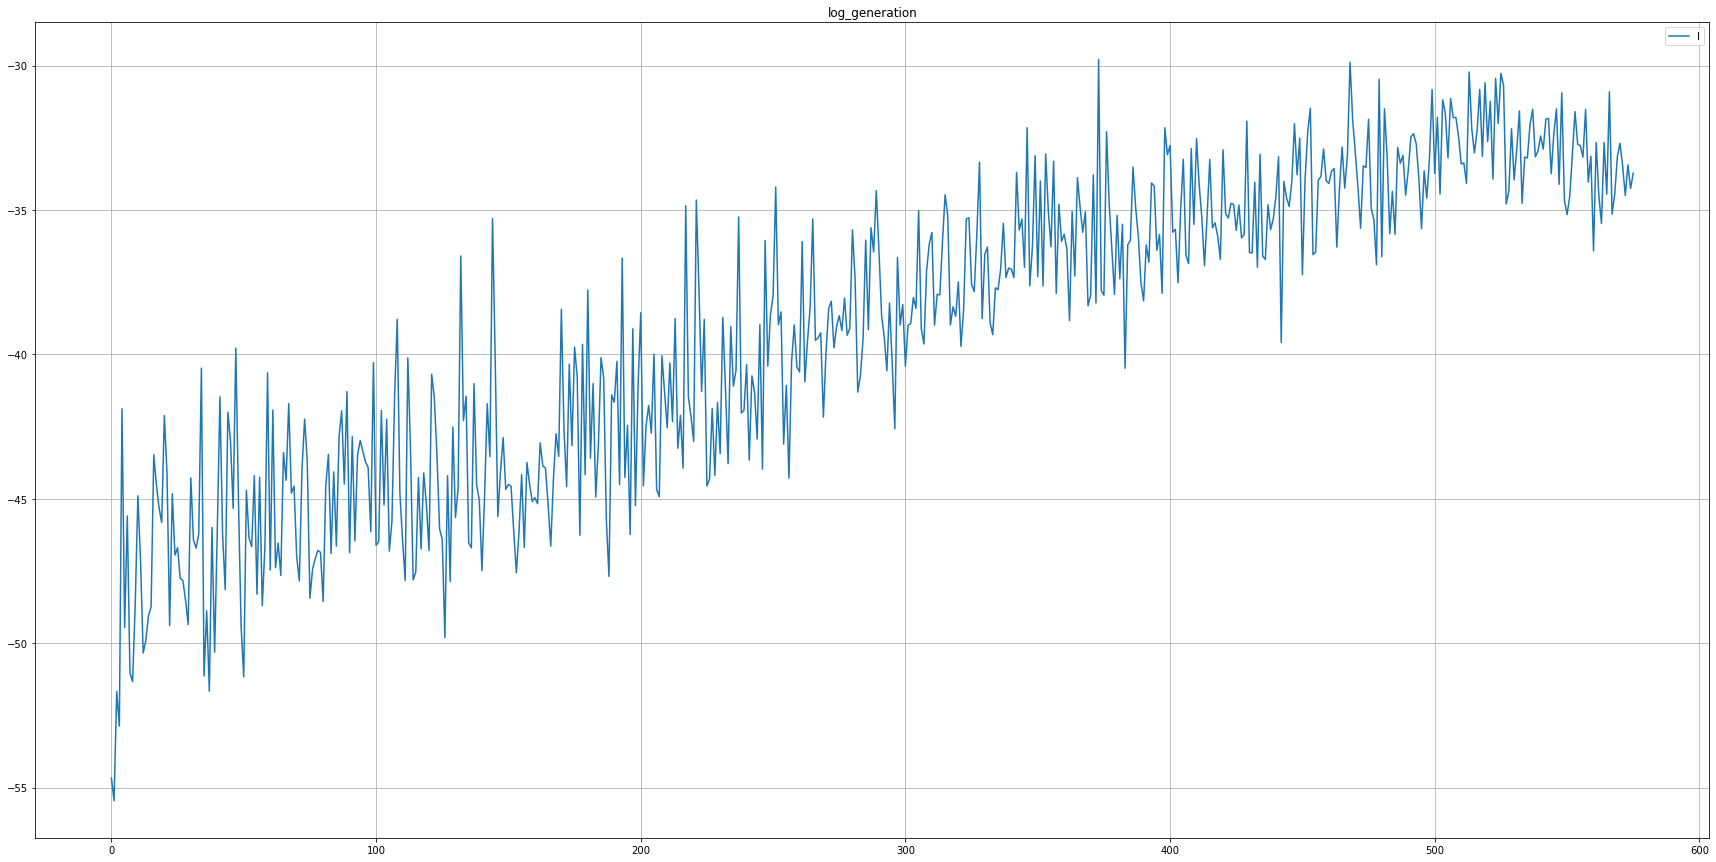

In [47]:
plt.figure(figsize=(30, 15))
plt.title("log_generation")
plt.plot(best_scores_in_generations_log, label='I')

plt.legend()
plt.grid(visible=True)

In [48]:
#import pickle

In [49]:
file_es = open('serialised_data_CMAES_MarkovDelta_t/evalution_strategy.pkl', 'wb')


In [50]:
pickle.dump(es.es, file_es)


In [51]:
file_es.close()

In [52]:

file_params = open('serialised_data_CMAES_MarkovDelta_t/best_params.pkl', 'wb')

file_log = open('serialised_data_CMAES_MarkovDelta_t/logs_relu_linear_norm_2out.pkl', 'wb')
file_dict_score_solution = open('serialised_data_CMAES_MarkovDelta_t/score_solution_relu_linear_norm_2out__number3.pkl', 'wb')

pickle.dump(best_solution, file_params)

pickle.dump(best_scores_in_generations_log, file_log)

max_min_score_solution = [best_score_solution, worst_score_solution]
pickle.dump(max_min_score_solution, file_dict_score_solution)

file_params.close()

file_log.close()
file_dict_score_solution.close()
